- 博客地址：https://www.cnblogs.com/bobo-zhang/p/11243138.html

- 爬取的网站：https://www.aqistudy.cn/html/city_detail.html
- 分析：
    - 1.修改查询条件（城市的名称+时间范围），点击查询按钮，捕获点击按钮后发起请求对应的数据包。点击查询按钮后，发起的是ajax请求。该请求就会将指定查询条件对应的数据加载到当前页面中。（我们要爬取的数据就是该ajax请求请求到的数据）
    - 2.分析捕获到的数据包
        - 提取出请求的url:https://www.aqistudy.cn/apinew/aqistudyapi.php
        - 请求方式:post
        - 请求参数:d:动态变化一组数据（且加密）
        - 响应数据：是加密的密文数据
            - 问题：该数据包请求到的是密文数据，为何在前台页面显示的缺失原文数据？
            - 原因：请求请求到密文数据后，前台接受到密文数据后使用指定的解密操作（js函数）对密文数据进行了解密，然后将原文数据显示在了前台页面。
       - 下一步工作的步骤：
           - 首先先处理动态变化的请求参数，动态获取该参数的话，就可以携带该参数进行请求发送，将请求到的密文数据捕获到。
           - 将捕获到的密文数据找到对应的解密函数对其进行解密即可。
           - 【重点】需要找到点击查询按钮后对应的ajax请求代码，从这组代码中就可以破解动态变化的请求参数和加密的响应数据对应的相关操作。
    - 3.找ajax请求对应的代码，分析代码获取参数d的生成，和加密的响应数据的解密操作
        - 基于火狐浏览器定位查询按钮绑定的点击事件。
        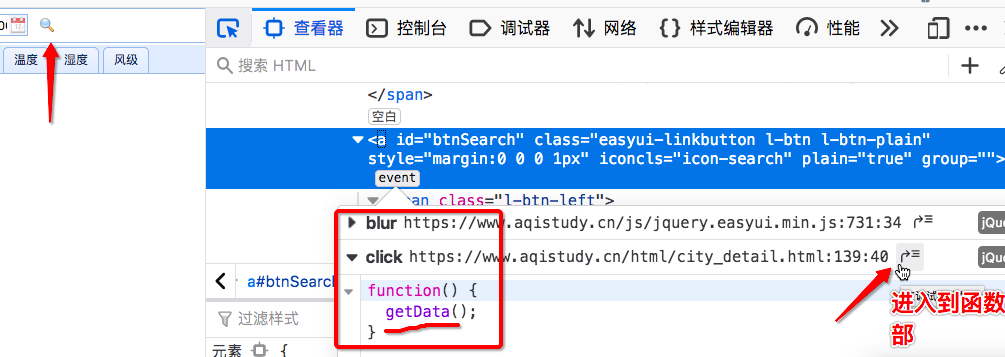
    

- 从getData函数实现中找寻ajax请求对应的代码
    - 在该函数的实现中没有找到ajax代码，但是发现了另外两个函数的调用
        - getAQIData();getWeatherData();ajax代码一定是存在于这两个函数实现内部
        - type == ’HOUR‘：查询时间是以小时为单位
- 分析getAQIData();getWeatherData()：找到ajax代码
    - 没有找到ajax请求代码
    - 发现了另一个函数调用：getServerData(method,param,func,0.5)
        - method = 'GETCITYWEATHER' or 'GETDETAIL'
        - params = {city,type,startTime,endTime}:查询条件
- 分析getServerData，找寻ajax代码：
    - 基于抓包工具做全局搜索
    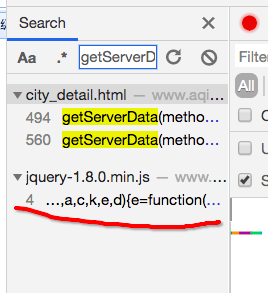
    - 找到的函数实现竟然被加密

- 对getServerData加密的实现进行解密？？
    - js混淆：对核心的js代码进行加密
    - js反混淆：对js加密代码进行解密
        - 暴力破解：https://www.bm8.com.cn/jsConfusion/
        - 终于看到了ajax实现的代码
        - 分析结论：
            - data:加密的响应数据
                - decodeData(data)将加的响应数据进行解密
                    - 参数data：加密的响应数据
            - param：动态变化且加密的请求参数
                - getParam(method, object)返回动态变化的请求参数
                    - 参数method：method = 'GETCITYWEATHER' or 'GETDETAIL'
                    - 参数object： {city,type,startTime,endTime}:查询条件
                

- js逆向
    - 现在只需要调用两个js函数（decodeData，getParam）返回结果即可。在python程序中如何调用js函数。
    - js逆向：在python中调用js函数
        - 方式1：
            - 手动的将js函数改写称为python函数
        - 方式2：
            - 使用固定模块实现自动逆向（推荐）
            -  PyExecJS 库来实现模拟JavaScript代码执行获取动态加密的请求参数，然后再将加密的响应数据带入decodeData进行解密即可！
                - pip install PyExecJS
                - 在本机安装好nodejs的环境

- PyExecJS的使用

In [2]:
#基于该模块模拟执行getParam返回动态变化的请求参数
import execjs
 
node = execjs.get()
 
# Params
method = 'GETCITYWEATHER'
city = '北京'
type = 'HOUR'
start_time = '2018-01-25 00:00:00'
end_time = '2018-01-25 23:00:00'
 
# Compile javascript
file = 'jsCode.js'
ctx = node.compile(open(file,encoding='utf-8').read())
 
# Get params
js = 'getPostParamCode("{0}", "{1}", "{2}", "{3}", "{4}")'.format(method, city, type, start_time, end_time)
params = ctx.eval(js)#eval执行指定的js函数
print(params)

tdgHOYxwKdDSgYXe+RLPzYCgLvrddahasI5XXklB4gVLYqab+XRPpMD/oSqnJ/aEmFwzVEUhLnPzRy03+X1BI4qc9EYeRPqiKrT+f1JQExGQ4ii8kKvZhGH+nPffaX/xq5iLB6vblcvBC/L8e6Uxdok4qUMELj08K03SsYBTdgbJ5+pjXxS52cy07KRV7ubKXk5rZ3T0NQ3CLbYwsAYX30uAf19PwqiTLbUc5xwsANOf5ZiRMvhcs46DOCpi887ok71u8J1yM+ZHrrnX/WbFT869B8mrKpdEAH5TvqtkUsOv8bVIsBbpbt/ZhljT1NR+tA9LLDlDH3wG74mk9PyIVj2MnkkZRpkW7Vyt20UwLvBeszkgBYRNxg4SJuuvJMBg9UJ0LTXYXpazJwvWej2xoDka0S91JIBoju88RH0PCL29hK2eYJetQmQhpBa6Jz3h4xOanj9PApecuTguuC8X5KB1q/D8Lk/DSGA6wo9qsoo=


In [3]:
#携带上动态变化的请求参数d进行请求发送，获取加密的响应数据
import requests
url = 'https://www.aqistudy.cn/apinew/aqistudyapi.php'
data = {
    'd':params
}
page_text = requests.post(url=url,data=data).text
page_text

'32oGK2qWJh7telbphZM5ADK9Jj+QamTnz/s2/03K0GFymBvUHnASsk3UaSWnZj/rAe9sqbmuJJX+ZiRZdk9LjPPWs9qITRy89Jt/EzC3YGSq3+edS62Fl6dnvE5L1B3mqS9KJFrrwUAJ/Amu2V1bOg=='

In [ ]:
#模拟执行decodeData的js函数对加密响应数据进行解密
import execjs
import requests

node = execjs.get()
 
# Params
method = 'GETCITYWEATHER'
city = '北京'
type = 'HOUR'
start_time = '2018-01-25 00:00:00'
end_time = '2018-01-25 23:00:00'
 
# Compile javascript
file = 'jsCode.js'
ctx = node.compile(open(file,encoding='utf-8').read())
 
# Get params
js = 'getPostParamCode("{0}", "{1}", "{2}", "{3}", "{4}")'.format(method, city, type, start_time, end_time)
params = ctx.eval(js) #请求参数d

#发起post请求
url = 'https://www.aqistudy.cn/apinew/aqistudyapi.php'
response_text = requests.post(url, data={'d': params}).text#加密的响应数据

#对加密的响应数据进行解密
js = 'decodeData("{0}")'.format(response_text)
decrypted_data = ctx.eval(js)#返回的是解密后的原文数据
print(decrypted_data)
#执行会报错：目前页面中没有数据。解密函数只是针对页面中原始的数据进行解密。

function getServerData(method, object, callback, period) {
        const key = hex_md5(method + JSON.stringify(object));
        const data = getDataFromLocalStorage(key, period);
        if (!data) {
            var param = getParam(method, object);
            $.ajax({
                url: '../apinew/aqistudyapi.php',
                data: {
                    d: param
                },
                type: "post",
                success: function (data) {
                    data = decodeData(data);
                    obj = JSON.parse(data);
                    if (obj.success) {
                        if (period > 0) {
                            obj.result.time = new Date().getTime();
                            localStorageUtil.save(key, obj.result)
                        }
                        callback(obj.result)
                    } else {
                        console.log(obj.errcode, obj.errmsg)
                    }
                }
            })
        } else {
            callback(data)
        }
    }

In [ ]:
$(function () { 
    $(".submit").on("click", function () {
        var sub = $(".search").val()	//拿到输入框的值
        $.ajax({
            type: "POST",    //请求类型 
            url: 'https://www.aqistudy.cn/apinew/aqistudyapi.php',    //请求地址和参数    GET请求才把参数写在这里
            data: d
            #res加密的响应数据
            success: function (res) {   //请求成功后执行的函数res是返回的值
                xxxx #在对res的密文数据进行解密
                                     
            }
        });
    });
});


- js加密
- js解密
- js混淆
- js反混淆
- js逆向（***）